# Minimal encoding with VRP tutorials

### Contents
* [Introduction](#introduction)
* [Notations](#notations)
* [Minimal Encoding scheme](#scheme)
* [Implementation of minimal encoding](#min)
     * [ Quantum state and ansaz](#min-1)
     * [Cost function](#cost)
     * [Optimisation](#opt)
* [VRP](#vrp)
* [Solving VRP](#solvevrp)

$$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|} $$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

## Introduction <a class='anchor' id='introduction'></a>

This tutorials introduce you to an implementation of encoding scheme from the following papers : <br>
* [Qubit-efficient encoding schemes for binary optimisation problems](https://quantum-journal.org/papers/q-2021-05-04-454/)　(21 Apr 2021) -- (1)
* [Qubit efficient quantum algorithms for the vehicle routing problem on quantum computers of the NISQ era](https://arxiv.org/abs/2306.08507)　(14 Jun 2023) -- (2)

The main focus of this tutorial is to expload a possibility of minimal encoding which is a encoding scheme for QUBO problem by reproducing the procedure consider by refrences (1) and (2). In these days there exists various encoding scheme for different problems (Machine learning, numerical optimization etc) and main purpose of these schemes are to encode classical problem into a quantum problem so it can be solve using quantum problem. Main motivation behind this is that there exists a possibility of quantum computing being more efficient than classical computing. <br>

However, current quantum devices (NISQ) known to have two main problems which are noise and limitted number qubits. 
To deal with these problems from software side, there are researches on error correction and error mitigation to deal with noise and on different encdoing methods to deal with limitation of number of qubits availble. <br> 
Minimal encoding belong to the second case. Specifically, to encode QUBO problem into quantum.

For instance QUBO can be solve using QAOA. In this case, QUBO will be encode into Ising Hamiltonian. <br> 
In this case, it requires the same number of qubits as classical variable. So if we have 10 variables in QUBO model, then we need 10 qubits in order to encode QUBO into Ising Hamiltonian. You may realise that with real world problems, this method we will reach the limit of current quantum device pretty quickly. <br> 
This also apply to other problems, as well.<br>

This tutorial introduce a minimal encoding scheme which aim to over come this limitation cause by limited number of qubits availble on current quantum divices.

## Notations

These are notations used in this tutorials.

* $n_c$ : classical bit
* $n_q$ : quantum bit
* $n_r$ : quantum register bit
* $n_a$ : quantum ancila bit
* $ l $ : number of layer for quantum circuit (ansaz)


## Minimal Encoding scheme <a class='anchor' id='scheme'></a>

With this minimal encoding scheme, the number of qubits require for classical bits is reduced. Specifically, it requires $\log_2 n_c$ quantum register bits and 1 quantum ancila bits. Therefore, the number of qubits it use is $$ n_q = \log_2 n_c + 1 $$

We will discuss only mathmatical formulas in this section. All implementations will be on the next section.

To encode QUBO problem, we use the following parameterised quantum state
$$ \tag{1} \ket{\psi_1 (\vec{\theta})} = \sum^{n_c}_{i=1} \beta_i (\vec{\theta})[a_i(\vec{\theta}) \ket{0}_a + b_i (\vec{\theta}) \ket{1}_a] \otimes \ket{\phi_i}_r $$

where
$$\{ \ket{\phi_i}_r \} \text{ : computational basis of regsister qubits} $$

$$\{ \ket{0}_a , \ket{1}_a \} \text{ : computational basis of ancilla qubit} $$

To define one-to-one correspondence between each of the $n_c$ classical variables $x_i$ in $\vec{x}$ and a unique basis state $\ket{\phi_i}_r$, the probability of the $i^{th}$ classical variable to have 0 or 1 can be determin as follow : 
$$ Pr(x_i = 1) = |b_i|^2  $$
$$ Pr(x_i = 0) = 1- |b_i|^2 = |a_i|^2 $$

Additionally,  $\beta_i(\vec{\theta})$ capture the likelihood of measuring each register state $\ket{\phi_i}$ and corresponding ancilla qubit

For example, to encoding the probability distribution over all solutions $\vec{x}$ of dimentions $n_c = 4$ which requires $n_r = 2$, mapping will be look like 
$$ \ket{\phi_1}_r = \ket{00}_r, \ket{\phi_2}_r = \ket{01}_r, \ket{\phi_3}_r = \ket{10}_r,\ket{\phi_4}_r = \ket{11}_r $$ and if $ \vec{x} = (1,0,0,1) $
then we have 
$$\ket{\psi_1} = (\ket{1}_a\ket{00}_r+\ket{0}_a\ket{01}_r + \ket{0}_a\ket{10}_r + \ket{1}_a\ket{11}_r)/2 $$

*This scheme can encode only distribution functions of statistically independent classical variables, which is a limitation of minimal encoding

As with standard VQAs, we define cost function as follow : 
$$ C_1(\vec{\theta}) = \sum_{i,j=1}^{n_c} A_{ij} \frac{\langle \hat{P_i^1}\rangle_{\vec{\theta}} \langle \hat{P_i^j}\rangle_{\vec{\theta}}}{\langle \hat{P_i}\rangle_{\vec{\theta}}\langle \hat{P_j}\rangle_{\vec{\theta}}}(1-\delta_{ij}) + \sum_{i=1}^{n_c} A_{ii} \frac{\langle \hat{P}^1_i \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$

where : 
$$ \hat{P}_i = \ket{\phi_i}\bra{\phi_i}_r \text{ : projectors over registers, independent of the ancilla state }$$
$$ \hat{P}^1_i = \ket{1}\bra{1}_a \otimes \hat{P}_i \text{ : projectors over registers with ancilla being }\ket{1}_a$$

then, expectation values are expresses as follow : 
$$ \langle \hat{P}_i \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})} $$
given that 
$$ b_i(\vec{\theta}) = \langle \hat{P}_i^1 \rangle_{\vec{\theta}} / \langle \hat{P}_i \rangle_{\vec{\theta}} $$
For a detailed derivation of the cost function, please check the appendix of the paper.

This cost function is to minimise the parameters $ \vec{\theta} $. Global minimum of the cost function is the exact solution to minimize QUBO.

The highly entangled quantum state that minimize (6) : $\ket{\psi} = \sum_i \beta_i \ket{\sigma_i}_a \otimes \ket{\phi_i}$ with $\sigma = \{ 0,1 \}$ and corresponds unambiguously to the exact solution $\vec{x} = [\sigma_1, .... , \sigma_{n_c}]$ that minimize QUBO define by $A$. 

$C_1 (\vec{\theta})$ is only depends on the set of norm $\{ |b_i|^2 \}$, so measurements on computational basis is sufficient for estimation. <br>


The cost function cannot be reduce to a linear function of expectation values. That is why QUBO model of this encoding scheme cannot be describede with a suitable Hamiltonian. It means that we cannot use standfard Quantum optimization methods such as QAOA or VQA. 

So, we follow the following optimization procedure : 
1. Start with random starting point $\theta_{init}$.
2. Measure the quantum state in computation basis ($\{ 0, 1 \}$)
3. Feed result to classical optimizer which update parameter $\theta_{new}$
4. After the function is minimzed, with the final quantum state $\ket{\psi(\vec{\theta}_{opt})}$, a set of solutions $\{ \vec{x} \}$ with value $C_x = xAx$ are obtained by sampleing each variable independently follwing $ Pr(x_i = 1) = |b_i|^2 $

## Implementation of minimal encoding <a class='anchor' id='min'></a>

In this section, we will see how to implement each part of minimal encoding with Python. 
1. Quantum state and ansaz (parameterised quantum circuit) 
2. Cost function 
3. Optimization procedure

### Quantum state and ansaz <a class='anchor' id='min-1'></a>

First, we import all necessary libraries.

In [1]:
import qiskit as qk
from qiskit import QuantumRegister, AncillaRegister , QuantumCircuit
from qiskit.circuit import  ParameterVector

from math import pi
import numpy as np

The initial quantum state (1) is produced by applying parameterized unitary evolution to initial product state $\ket{\psi_0}$ which can be express as follow : 

$$ \ket{\psi_1(\vec{\theta})} = \hat{U_1}(\vec{\theta})\ket{\psi_0} $$ 

This can be express as hardware efficient quantum circuit, and a single layer of this circuit is ... 

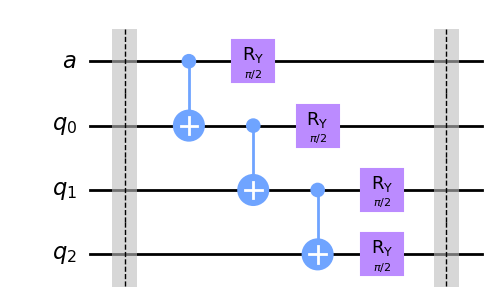

In [2]:
qreg_q = QuantumRegister(3, 'q')
areg_a = AncillaRegister(1, 'a')

circuit = QuantumCircuit(areg_a, qreg_q)
circuit.barrier()
circuit.cx(areg_a[0], qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ry(pi / 2, areg_a[0])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.ry(pi / 2, qreg_q[0])
circuit.ry(pi / 2, qreg_q[1])
circuit.ry(pi / 2, qreg_q[2])
circuit.barrier()


circuit.draw(output='mpl')

There is no specific number of layer specified for this encoding scheme, so you can set it to any number. However, if you increase the number of layer, it increases the number variables thus it increase the number of computations for every iteration of optimization. 4 is good number of layer to start with. 

To construct the ansaz circuit, first we need to define the number of qubits ($n_r + n_a$) which is based on the problem and the number of layer. 

In [3]:
#example
nr = 3
na = 1
nq = 4
l = 4

Then we generate parameters with random numbers.

In [4]:
def init_parameter(nq:int , l:int):
    #initialize a parameters
    parameters = ParameterVector('θ', nq*l)
    #create a dictionary of parameters with random values and return it
    theta =  {parameter: np.random.random() for parameter in parameters}
    return parameters, theta

We now generate a parameterized circuit (ansaz). Do not forget to apply Hadmard gate as a first step before adding layers.

In [5]:
def generate_circuit(nr:int, na:int, l:int, parameters:np.array)->qk.circuit.quantumcircuit.QuantumCircuit:
    #define number of qubits
    nq = nr + na
    qreg_q = QuantumRegister(nr, 'q')
    areg_a = AncillaRegister(na, 'a')
    circuit = QuantumCircuit(areg_a, qreg_q)

    #add H gate for each qubit
    circuit.h(areg_a[0])
    for i in range(0,nr):
        circuit.h(qreg_q[i])
    circuit.barrier()
  
    #add layers which consist of CNOT and Ry gate
    for j in range(0,l):
        #CNOT
        # circuit.cx(qreg_q[0],areg_a[0])
        circuit.cx(areg_a[0],qreg_q[0])
        for i in range(nr):
            if i != 0:
                # circuit.cx(qreg_q[i],qreg_q[i-1]) 
                circuit.cx(qreg_q[i-1],qreg_q[i]) 

        #Ry
        for i in range(nq):
            if i == 0:
                circuit.ry(parameters[nq*j+i], areg_a[i])
            else:
                circuit.ry(parameters[nq*j+i], qreg_q[i-1])  
        circuit.barrier()
    return circuit

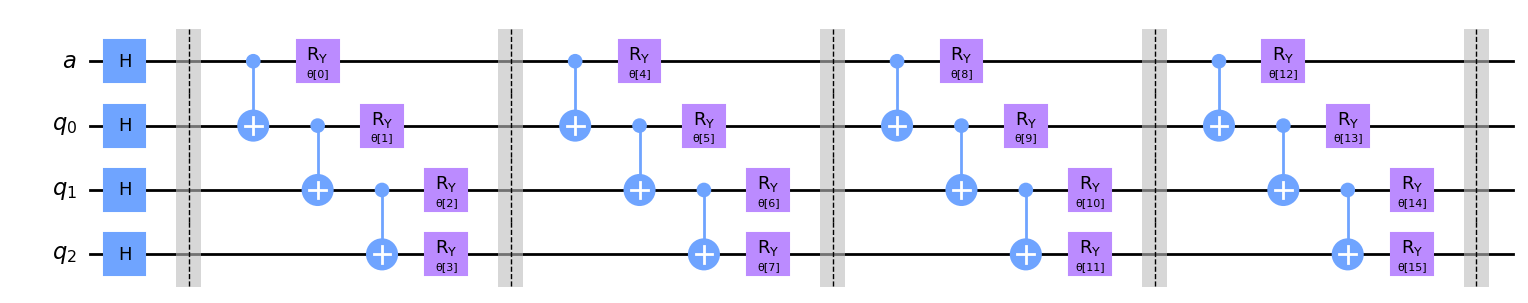

In [6]:
parameters, theta = init_parameter(nq, l)
circuit = generate_circuit(nr, na, l, parameters)
circuit.draw(output='mpl')

### Cost function <a class='anchor' id='cost'></a>

Recall the cost function : 
$$ C_1(\vec{\theta}) = \sum_{i,j=1}^{n_c} A_{ij} \frac{\langle \hat{P}_i^1\rangle_{\vec{\theta}} \langle \hat{P}_i^1\rangle_{\vec{\theta}}}{\langle \hat{P}_i\rangle_{\vec{\theta}}\langle \hat{P}_j\rangle_{\vec{\theta}}}(1-\delta_{ij}) + \sum_{i=1}^{n_c} A_{ii} \frac{\langle \hat{P}^1_i \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$

Summation can be express using nested for loop, and setting each expectation values as $P$ and $P^1$ we can easily write a function as follow : 

In [7]:
def init_cost_function(A:np.ndarray, nc:int):
    #define cost function
    def cost_function(P1:np.array, P:np.array)->float:
        # first sum of cost function 
        first_sum = 0
        for i in range(nc):
            for j in range(nc):
                if i != j:
                    # first_sum += A[i][j]*(P1[i]*P1[j])/(P[i]*P[j])
                    first_sum += A[i][j]*(P1[i]/P[i])*(P1[j]/P[j])
                # else:
                #     first_sum += A[i][i]*(P1[i]/P[i])
        # second sum of cost function 
        second_sum = 0
        for i in range(nc):
            second_sum += A[i][i]*(P1[i]/P[i])

        result = first_sum + second_sum
        return  result
    
    return cost_function

Where $A$ is a real symetric matrix from QUBO. <br> 
We define function inside another function just so we don't have to pass $A$ every time we compute cost function.

We talk about how to compute expectation value on the next section.

### Optimisation <a class='anchor' id='opt'></a>

In [8]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

import itertools


Recall that we cannot use general quantum optimization algorithm such as QAOA and VQA, we need to set a procedure. 
The main thing on this part is to implement the function that will be optimized using classical optimizor.
Actually, we already implemented the cost function but we have not implement how to obtain values for $P$ and $P^1$. To obtain those values, we can use Qiskit Primitives Estimator (https://qiskit.org/documentation/apidoc/primitives.html). With this, we can easily compute the expectation values.

The expectation value can be compute as follow : 
$$ \bra{\psi_i(\theta_k)} H_j \ket{\psi_i(\theta_k)}$$
where : 
- $\psi(\theta)$ -> Quantum circuit
- $H_j$ -> Observable
- $\theta_k$ -> Parameter values

Quantum circuit is already implemented, and parameter values are updated every iteration of optimization. So now we need to implement the observables which is a list of Pauli operators. We can implement them easily using Qiskit SparsePauliOp (https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html#qiskit.quantum_info.SparsePauliOp)

Observables we are interested in this case is the all possible outcomes of the circuit. Since we measure the final quantum state with computational basis, observables are all possible combination of $\ket{0}$ and $\ket{1}$ <br>
Recall that $\sigma_Z \ket{0} = \ket{0}$ and $\sigma_Z \ket{1} = -\ket{1}$, we can see that Pauli operator for $\ket{0}$ and $\ket{1}$ are quite simple as follow : 
- $\ket{0} \: => \: \frac{1}{2}(\sigma_I + \sigma_Z) \ket{0}$
- $\ket{1} \: => \: \frac{1}{2}(\sigma_I - \sigma_Z) \ket{1}$
Now, we just need to combine them together using a tensor product. <br>
Let us now implement those Pauli Operators and the function for optimization. 

Recall that, 
$$ \langle \hat{P}_i \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})} $$
$$ \langle \hat{P}_i^1 \rangle_{\vec{\theta}} = \bra{\psi_1 (\vec{\theta})}\hat{P}_i^1 \ket{\psi_1 (\vec{\theta})} $$
where 
$$ \hat{P}_i = \ket{\phi_i}\bra{\phi_i}_r \:,\:\:\hat{P}^1_i = \ket{1}\bra{1}_a \otimes \hat{P}_i $$

In [9]:
def define_pauli_op(nr:int, ancilla:bool=False)->list[SparsePauliOp]:
    #total number of qubits (nq+na) where na is number of ancilla qubits and is always 1
    #get all binary 2^nq pattern
    l = [list(i) for i in itertools.product([0, 1], repeat=nr)]
    l = np.array(l)

    #basic pieces of SparsePauliOp 
    #PauliOp for |0> 
    P0 = SparsePauliOp.from_list([('I', 1/2), ('Z', 1/2)])
    #PauliOp for |1> 
    P1 = SparsePauliOp.from_list([('I', 1/2), ('Z', -1/2)])
    #Indentiy op
    Id = SparsePauliOp.from_list([('I', 1)])

    #init list of SparsePauliOp 
    pauli_op = []
    for i in range(len(l)):
        pauli_op.append(SparsePauliOp.from_list([('',1)]))
        for j in l[i]:
            if j == 0:
                #|0>
                pauli_op[i] = pauli_op[i].tensor(P0)
            else: 
                #|1> 
                pauli_op[i] = pauli_op[i].tensor(P1)

    #add ancilla qubit
    for i in range(len(pauli_op)):
        if ancilla == True:
            pauli_op[i] = pauli_op[i].tensor(P1)
        else:
            pauli_op[i] = pauli_op[i].tensor(Id)
    
    return pauli_op

In [10]:
def init_func(nc:int, nr:int, na:int, 
              circuit:qk.circuit.quantumcircuit.QuantumCircuit,
              A:np.ndarray, 
              progress_history:list,
              num_shots:int = None):
    nq = nr + na
    #get expectation values from a circuit
    #get a list of H (observables), which is a list of SparsePauliOp
    H = define_pauli_op(nr)
    Ha = define_pauli_op(nr, ancilla=True)
    
    cost_function = init_cost_function(A, nc)
    
    #using IBM simulator or quantum device
#     service = QiskitRuntimeService(channel="ibm_quantum", token="c2ceaa1ae11ea3b0fecd9657e6f3355f8063b077e84e743f28452c6493c42431060f6dd8c124e396f4c72cda329630fef92088c341f0353a77524d79945734dd")
#     backend = service.backend("ibmq_qasm_simulator")
#     estimator = Estimator(backend=backend)
    
    
    estimator = Estimator()
    
    if num_shots is not None:
        estimator.set_options(shots=num_shots)
    
    def func(theta:dict)->float:
        #get a expectation value of each H
        job1 = estimator.run([circuit]*len(H),H,[theta]*len(H))
        P = job1.result()
        # print(f"The primitive-job finished with result {P}")

        job2 = estimator.run([circuit]*len(H),Ha,[theta]*len(H))
        P1 = job2.result()
        # print(f"The primitive-job finished with result {P1}")

        result = cost_function(P1.values, P.values)
        #keep progress of the minimization just so we can plot it later
        progress_history.append(result)
        # print(f"The result of cost function is {result}")
        return result

    return func

Again, we define function inside another function so we don't have to pass so many parameters every iteration of the optimization. Only parameter change on each iteration is the $\theta$ <br>
Side note:notice that you can set the number of shot (or number of measurememnt). When it is not set for any number, it computes exact expectation value. We found that, setting it to None produces the most stable result overall. But you are welcome to experiment with it

After the $\theta$ value is minimized, we will get the final quantum state using the final values of $\theta$. Then obtain the final array of binary based on the probability. <br> 
Recall the quantum state we initially define : 
$$\ket{\psi_1 (\vec{\theta})} = \sum^{n_c}_{i=1} \beta_i (\vec{\theta})[a_i(\vec{\theta}) \ket{0}_a + b_i (\vec{\theta}) \ket{1}_a] \otimes \ket{\phi_i}_r $$
We obtain the final binary array based on the ancila qubits which are define with probability s.t. 
- $Pr(x_i = 1) = |b_i|^2$
- $Pr(x_i = 0) = 1 - |b_i|^2$ <br>

These probability can be computed by : 
$$ b_i(\vec{\theta}) = \frac{\langle \hat{P}_i^1 \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}}$$
consider that 
$$ \frac{\hat{P}_i^1}{\hat{P}_i} = \frac{\ket{1}\bra{1}_a \otimes \ket{\phi_i}\bra{\phi_i}_r}{\ket{\phi_i}\bra{\phi_i}_r} = \ket{1}\bra{1}_a$$
so we can find $b_i(\theta)$ by : 
$$ 
\frac{\langle \hat{P}_i^1 \rangle_{\vec{\theta}}}{\langle \hat{P}_i \rangle_{\vec{\theta}}} = 
\frac{\bra{\psi_1 (\vec{\theta})}\hat{P}_i^1 \ket{\psi_1 (\vec{\theta})}}{\bra{\psi_1 (\vec{\theta})}\hat{P}_i \ket{\psi_1 (\vec{\theta})}} $$

After compute all $|b_i(\vec{\theta})|^2$, we also have $|a_i(\vec{\theta})|^2 = 1 - |b_i(\vec{\theta})|^2$. 
The function below decide $x_i$ on those two values such that 
- If $|b_i(\vec{\theta})|^2 > |a_i(\vec{\theta})|^2 => x_i = 1$ 
- Else $x_i = 0$

Please note that the function below does not take into account the case when $|b_i(\vec{\theta})|^2 \text{ and } |a_i(\vec{\theta})|^2 $ are very close to each other or equal. Simply because we never had such case while trying to solve optimization problems with minimal encoding. 

In [11]:
def get_ancilla_prob(theta:dict, 
                     circuit:qk.circuit.quantumcircuit.QuantumCircuit, 
                     nr:int)->np.array:
    estimator = Estimator()
    #define observable to calculate expectation value
    H = define_pauli_op(nr, ancilla=False)
    Ha = define_pauli_op(nr,ancilla=True)
    #get expectation values from
    job1 = estimator.run([circuit]*len(H),H,[theta]*len(H))
    P = job1.result()
#     print(f"The primitive-job finished with result {P}")
    job2 = estimator.run([circuit]*len(H),Ha,[theta]*len(H))
    P1 = job2.result()
#     print(f"The primitive-job finished with result {P1}")
    #compute b_i and a_i
    b_sq=[] # list of probability of ancilla qubit being |1>
    a_sq=[] # list of probability of ancilla qubit being |0>
    for i in range(len(P.values)):
        val = (P1.values[i] / P.values[i])**2
        b_sq.append(val)
        a_sq.append(1 - b_sq[i])

    final_binary = []
    #compare a and b and pick the larger one
    for i in range(len(a_sq)):
        if a_sq[i] > b_sq[i]:
            final_binary.append(0)
        else:
            final_binary.append(1)

    print(f"b is Pr(x=1){b_sq}")
    print(f"a is Pr(x=0){a_sq}")
    #need to fix return value
    # print(f"final binary is {final_binary}")
    final_binary = np.array(final_binary)
    return final_binary

The return value of the function corresponds to the solution $\vec{x}$ that minimized QUBO problem.

## VRP <a class='anchor' id='vrp'></a>

First, we import all necessary libraries for this section

In [12]:
import jijmodeling as jm
import geocoder as gc
import math

In this section we define the VRP we consider for this tutorial, and implement it.

VRP is well known combinational optimization problem where goal is to find the best set of routes for fleet of vechiles. Definition of "the best set of routes" changes depends on how you define the problem.
There are various different varient of VRP and also, there are many different ways to solve it. 

One of example for VRP is optimizing the delivery system in Japan. Japanese delivery oftern has specific time and date that a packet need to be delier to a certain customer. With VRP, you can find the best combination of routes for fleet of vechiles that is efficient and satisfies all requirements (time and date). Also, you might need to consider the capacity of each vechicles etc. 

The refrence (2) uses VRPWT (Vechile routing problem with time window) with route based formulation. 
With the route based formulation, first we generate possible routes with given locations, then feed the costs of those routes to optimizer to find the best set of routes. So key part of this formulation is how to generate routes and what constraints we set such as time window and vechicle capacity. Time window is one of the component that we take into consideration when we generate routes.
However, adding those limitations increase complexity of route generating process. 
Considering that our focus here is minimal encoding and not VRP, we are not considering time window and just using simplest form of VRP to explore the possibility of ninimum encoing.

The VRP we define for in this case only consider the cost of each rotue which is a distance. We also have constrain where each locations are visited only once except the depot where all vechicle depart and return to. <br>

First, we define each variables and implement a mathmatical formula using JijModeling : 

- R: set of routes 
- r: $r \in R$, each routes
- N: set of locations
- n: $n \in N$, each location
- i: each location except the depot
- x: $x\in \{ 0, 1 \}$
- d: $\delta$, equal to 1 if node $i$ lies in route $r$ and 0 otherwise

In [13]:
def set_problem():
    # Define the problem
    c = jm.Placeholder('c', ndim=1) #cost of each route
    n = jm.Placeholder('n', ndim=1) #node (location)
    d = jm.Placeholder('d', ndim=2).set_latex(r'\delta') #delta

    R = c.shape[0].set_latex("R") #set of routes
    N = n.shape[0].set_latex(r'\mathscr{N}') #set of nodes which is locations
    r = jm.Element('r', belong_to=(R)) 
    i = jm.Element('i', belong_to=(1,N))
    x = jm.BinaryVar('x', shape = R)


    problem = jm.Problem('VRPTW')
    problem += jm.sum(r, c[r]*x[r])
    const = jm.sum(r, d[r,i]*x[r])
    problem += jm.Constraint("one-time", const==1, forall=i)
    print(problem)

    return problem
set_problem()

Next, we generate instance data for the problem. <br> 
We can use random location but we define locations by ourselves for simplicity. We set only five locations so we can see if solution is correct or not.

For example : 

In [14]:
points = ['千代田区' ,'練馬区', '品川区', '文京区', '荒川区']
n = [index for index in range(len(points))] #index for each location

The first location on the points list is the depot.

In [15]:
depot = points[0]
depot

'千代田区'

We use Python library geocoder (https://pypi.org/project/geocoder/) to generate all location data.

In [16]:
def geo_information(points:list[str]):
     # get the latitude and longitude
    latlng_list = []
    try:
        for point in points:
            location = gc.osm(point)
            latlng_list.append(location.latlng)
        # make distance matrix
        num_points = len(points)
        inst_d = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(num_points):
                a = np.array(latlng_list[i])
                b = np.array(latlng_list[j])
                inst_d[i][j] = np.linalg.norm(a-b)
        geo_data = {'points': points, 'latlng_list': latlng_list}
        distance_data = {'d': inst_d}
    except:
        print("Your machine may not connect to the internet. Please check your connection.")
        print("If that's not the case, there may be a problem with the location you entered.")
        return 0

    # print(f'geo_data: {geo_data}')
    # print(f'distance: {distance_data}')
    return geo_data, distance_data

The most complex part of problem forming with VRP is route generating process. <br>
If you generate all possible routes, you will have $(N-1)!$ routes. Which becomes heavy operation quickly. To avoid this we implement greedy route genration. This method basically pick cheapest route (nearest next location) from current location. At the beggining, we set the number of vechicles and then set the number of location that each vechicles visit before returning to the depot. <br>
Initially, we set all possible outgoing route from the depot for the first vechcle, then go through nearest unvisited location and come back to the depot. Then, other vechicles go through nearest non-visited locations. Thus we only generate $(N-1)\times v$ routes at the most where $v$ is the number of vechcles.

In [17]:
#find nearest location from currebt location 
def find_min_distance(distance:list[float])->int:
    #copy the distance array 
    min_distance = min(distance)
    min_index = np.where(distance == min_distance)[0][0]
    # print(f'min_index: {min_index}')
    return min_index

#find unvisited nearest location 
def find_next_location(current_location:int, visited_location:list[int], distance_matrix:list[list[float]])->int:
    #get the distance from current location to other locations
    distance = distance_matrix[current_location].copy()
    #set the distance of visited location to infinity
    # print(f'distance 1: {distance}')
    for i in visited_location:
        distance[i] = math.inf
    # print(f'distance 2: {distance}')
    #find the next location
    next_location = find_min_distance(distance)
    return next_location

#this is delta that is part of mathmatical formula (based on the definiton on the paper)
def get_delta(route:list[int], n:int)->list:
    delta = np.zeros(n)
    for i in route:
        delta[i] = int(1)
    
    return list(delta)


def greedy_route_generating(points:list[str], v:int):
    #get the latitude and longitude and distance matrix
    geo_data, distance_data = geo_information(points)
    distance_matrix = distance_data['d']

    #set the maximum number of location that each vechicle can visit
    p = math.ceil((len(points)-1) / v)

    #initialized visited location 
    visited_location = []
    #initialize necessary dict and lists
    routes = {
        'route': [],
        'c': [], 
        'd': [], 
        'n': []
    }
    visited_location = []   
    initial_route = []
    #generate possible routes
    for i in range(1, len(points)):
        route = [0, i]
        initial_route.append(route) 
    # print(f'routes: {routes}')
    # print(f'test{routes[0][-1]}')
    # print(f'visited_location: {visited_location}')
    #generate routes
    for i in range(len(points)-1):
        # visited = [0]
        visited_location.append([0])
        count = 0 
        # print(f'visited_location: {visited_location}')
        # print(f'len(visited_location[i]): {len(visited_location[i])}')
        # print(f'len(points)-1: {len(points)-1}')
        while len(visited_location[-1]) != len(points):
            count += 1
            route = [0]
            cost = 0
            routes['route'].append(route)
            routes['c'].append(cost)
            # print(f'range p {p}')
            for j in range(p):
                if count == 1 and j == 0:
                    current_location = routes['route'][-1][-1]
                    next_location = initial_route[i][-1]
                    cost += distance_matrix[current_location][next_location]
                    routes['route'][-1].append(next_location)
                    visited_location[-1].append(next_location)
                else:
                    current_location = routes['route'][-1][-1]
                    next_location = find_next_location(current_location, visited_location[-1], distance_matrix)
                    cost += distance_matrix[current_location][next_location]
                    routes['route'][-1].append(next_location)
                    visited_location[-1].append(next_location)
                
            delta = get_delta(routes['route'][-1], len(points))
            routes['d'].append(delta)
            routes['route'][-1].append(0)
            routes['c'][-1] = cost
    # print(f'visited_location: {visited_location}')

    return routes

## Solving VRP <a class='anchor' id='splvevrp'></a>

First we import necessary libraries for this part.

In [18]:
import jijmodeling.transpiler as jmt
import openjij as oj
import matplotlib.pyplot as plt
import warnings
from qiskit.algorithms.optimizers import COBYLA
import dimod



/var/folders/lj/d00jpvwx00d3j_pnmjtgyzfh0000gn/T/ipykernel_4341/2803861982.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In this section, we actually solve VRP we defined on the previous section. <br>
First, we solve it using OpenJij to produce correct solution. Then we try to solve using minimal encosing and compare thoses solutions. 

We need to define some functions that are necessary to visualize solutions.

In [19]:
def get_routs_from_index(indecies:list[int], routes:list[list[int]])->list[list[int]]:
    optimised_routes = []
    for i in indecies:
        optimised_routes.append(routes['route'][i])
    
    return optimised_routes

def plot_route(routes:list[list[int]], geo_data:dict):
    #get the latitude and longitude and distance matrix
    points = geo_data['points']
    latlng_list = geo_data['latlng_list']

    #set the plot so you can plot Japanese
    plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
    #plot the points
    for i in range(len(points)):
        plt.plot(latlng_list[i][0], latlng_list[i][1], marker='o')
        plt.text(latlng_list[i][0], latlng_list[i][1], points[i])
    #plot the route
    for route in routes:
        route_points = []
        for i in route:
            route_points.append(latlng_list[i])
        route_points = np.array(route_points)
        plt.plot(route_points[:,0], route_points[:,1], marker='o')

    plt.title('ルート')
    plt.show()

    return 0

from abc import ABC, abstractmethod
from typing import List

#==========================================
#We also use some code written by 松山さん to get optimized routes

class LocalSearch(ABC):
    def __init__(self, distance_matrix: List[List[float]]):
        self.distance_matrix = np.array(distance_matrix)
        super().__init__()

    @abstractmethod
    def local_search(self, initial_solution: List[int]) -> List[int]:
        raise NotImplementedError

    def calculate_cost(self, solution: List[int]) -> float:
        return (
            np.sum(self.distance_matrix[solution[:-1], solution[1:]])
            + self.distance_matrix[solution[-1], solution[0]]
        )

class TwoOpt(LocalSearch):
    def local_search(self, initial_solution: List[int]) -> List[int]:
        best_solution = initial_solution
        improved = True

        while improved:
            improved = False
            for i in range(1, len(best_solution) - 2):
                for j in range(i + 1, len(best_solution)):
                    if j - i == 1:
                        continue  # changes nothing, skip then
                    new_solution = best_solution[:]
                    new_solution[i:j] = best_solution[
                        j - 1 : i - 1 : -1
                    ]  # this is the 2-optSwap
                    if self.calculate_cost(new_solution) < self.calculate_cost(
                        best_solution
                    ):
                        best_solution = new_solution
                        improved = True
        return best_solution
    
#==========================================


def two_opt_for_vrp(distance_data, routes, results):
    twoopt = TwoOpt(distance_data)
    sol_routes = []
    for result in results:
        routes[result] = twoopt.local_search(initial_solution=routes[result]) 
        sol_routes.append(routes[result])
    return sol_routes

In [23]:
def vrp_solution(result:oj.sampler.response.Response, 
                 pubo_builder:jmt.core.pubo.pubo_builder.PuboBuilder,
                 compiled_model:jmt.core.compile.compiled_model.CompiledInstance,
                 geo_data:dict,
                 distan_data:dict,
                 routes:dict):
    
    results = jmt.core.pubo.decode_from_openjij(result, pubo_builder, compiled_model)
    feasibles = results.feasible()
    print(f'feasibles: {feasibles}')
    objectives = np.array(feasibles.evaluation.objective)
    lowest_index = np.argmin(objectives)
    print(f"Lowest solution index: {lowest_index}, Lowest objective value: {objectives[lowest_index]}")
    nonzero_indices, nonzero_values, shape = feasibles.record.solution["x"][lowest_index]
    print("indices: ", nonzero_indices)
    print("values: ", nonzero_values)

    #get the routes from the indices
    optimised_routes = two_opt_for_vrp(distance_data['d'], routes['route'], nonzero_indices[0])    
    plot_route(optimised_routes, geo_data)

    return nonzero_indices[0]

First, we define problem, formalize instance data, and compile it into QUBO.

In [24]:
#set the warning off
warnings.filterwarnings('ignore')
# Define the problem
problem = set_problem()
#list of points, the first location is the depot
points = ['千代田区' ,'練馬区', '品川区', '文京区', '荒川区']
n = [index for index in range(len(points))]

#get geo data 
geo_data, distance_data = geo_information(points)
#generate routes
routes = greedy_route_generating(points, 3)
routes['n'] = n

print(f'routes: {routes}')
l = len(routes['route'])
print(f'number of routes => {l}')
# compile problem
compiled_model = jmt.core.compile_model(problem, routes, {})
# # Quadratic Unconstraint Binary Optimization (QUBO) model
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model=compiled_model)
# # qubo, const = pubo_builder.get_qubo_dict(multipliers = {'one-city': 0.5, 'one-time': 0.5})

qubo, const = pubo_builder.get_qubo_dict(multipliers = {'one-time': 500})

routes: {'route': [[0, 1, 3, 0], [0, 4, 2, 0], [0, 2, 3, 0], [0, 4, 1, 0], [0, 3, 4, 0], [0, 2, 1, 0], [0, 4, 3, 0], [0, 2, 1, 0]], 'c': [0.2806286635066365, 0.19659917858048687, 0.21533349711593272, 0.2175328162858192, 0.06749027534804625, 0.2904708371295728, 0.09305716566911103, 0.2904708371295728], 'd': [[1.0, 1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.0, 0.0]], 'n': [0, 1, 2, 3, 4]}
number of routes => 8


Solve with OpenJij.

feasibles: SampleSet(record=Record(solution={'x': [(([4, 7],), [1, 1], (8,)), (([4, 7],), [1, 1], (8,)), (([5, 6],), [1, 1], (8,)), (([5, 6],), [1, 1], (8,)), (([6, 7],), [1, 1], (8,)), (([2, 3],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,)), (([0, 1],), [1, 1], (8,))]}, num_occurrences=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), evaluation=Evaluation(energy=[-1998.5097770307016, -1998.3570541993024, -1998.679633361515, -1998.679633361515, -1998.3570541993024, -1998.3570541993024, -1998.679633361515, -1998.7676521470623, -1998.7676521470623, -1998.3570541993024], objective=[0.357961112477619, 0.357961112477619, 0.3835280027986838, 0.3835280027986838, 0.3835280027986838, 0.4328663134017519, 0.4772278420871234, 0.4772278420871234, 0.4772278420871234, 0.4772278420871234], constraint_violations={'one-time': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, pos

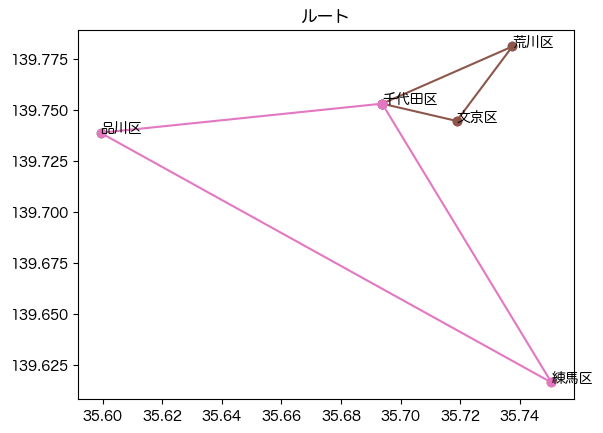

In [25]:
sampler = oj.SASampler()

# solve problem
# result = sampler.sample_qubo(qubo) 
result = sampler.sample_qubo(qubo, num_reads=10)

#get solution
vrp_result = vrp_solution(result, pubo_builder, compiled_model, geo_data, distance_data, routes)

Solve with minimal encoding

In [27]:
nc = len(routes['route']) #this is the number of routes
nr = math.log2(nc)
l = 4
na = 1
nq = int(nr + na)

if nr.is_integer() == False:
    print("The number of register qubits should be integer")
else: 
    nr = int(nr)

There are some other function we have not define that are necessary for minimal encoding.

In [28]:
def check_symmetric(A:np.ndarray, rtol=1e-05, atol=1e-08)->bool:
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

def convert_qubo_datatype(qubo:dict[tuple[int, int], float] , nc:int)->np.ndarray:
    qubo_matrix = np.zeros((nc, nc))
    for key, value in qubo.items():
        qubo_matrix[key[0], key[1]] = value 
    
    return qubo_matrix

We implemented minimal encoding on the OpenJij amd JijModeling.transpiler optimization pipeline. So there is a need for converting the datatype from np.array into a dimod.SampleSet

In [29]:
def get_sample(final_binary:np.array, energy:np.array)->dimod.SampleSet:
    sample = dimod.SampleSet.from_samples(
        dimod.as_samples(final_binary), 
        'BINARY', 
        energy=energy,
    )
    return sample

b is Pr(x=1)[4.464633082614925e-06, 2.8880859981427746e-05, 2.6749958143505954e-08, 8.943710494353442e-06, 0.9999922879402408, 0.9999504494169156, 6.413607315722231e-06, 2.1446006610212094e-05]
a is Pr(x=0)[0.9999955353669174, 0.9999711191400186, 0.9999999732500419, 0.9999910562895057, 7.71205975924616e-06, 4.9550583084423394e-05, 0.9999935863926843, 0.9999785539933898]
b is Pr(x=1)[4.3442507292932534e-20, 5.150230805319732e-20, 8.58963065530366e-21, 5.94127651406185e-23, 1.2774274520914087e-28, 0.999999999912101, 0.9999999998267552, 3.404446344256773e-24]
a is Pr(x=0)[1.0, 1.0, 1.0, 1.0, 1.0, 8.789902139483274e-11, 1.7324475187763255e-10, 1.0]
b is Pr(x=1)[8.891595297897806e-09, 1.0715313515575305e-07, 1.2006143483191629e-07, 1.3251236531005767e-07, 0.9999971087035071, 7.458432438548052e-10, 1.7737838288277488e-06, 0.999986966032431]
a is Pr(x=0)[0.9999999911084047, 0.9999998928468649, 0.9999998799385652, 0.9999998674876347, 2.8912964928906604e-06, 0.9999999992541567, 0.99999822621617

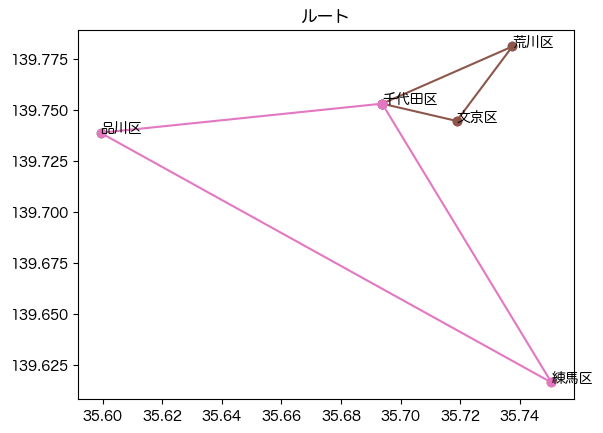

[4, 5]

In [31]:
#minimal encoding
A = convert_qubo_datatype(qubo, nc)
# print(A)
A = (A + A.T)
for i in range(len(A)):
    A[i][i] = A[i][i]/2
if check_symmetric(A) == False:
    print("The QUBO matrix is not symmetric")

final_binary = []
energy = []
for i in range(10):
    parameters, theta = init_parameter(nq, l) 
    circuit = generate_circuit(nr, na, l, parameters)
    progress_history = []

    # # print(A)
    func = init_func(nc, nr, na, circuit, A, progress_history)
    n_eval = 1000
    optimizer = COBYLA(maxiter=n_eval, disp=False, tol=0.00001)
    # optimizer = ADAM(maxiter=n_eval)
    result = optimizer.minimize(func, list(theta.values()))
    energy.append(np.array(result.fun))
    final_binary.append(get_ancilla_prob(result.x, circuit, nr))


sample = get_sample(final_binary, energy)
vrp_solution(sample, pubo_builder, compiled_model, geo_data,distance_data, routes)

Notice that on the reference (2), they use ADAM optimizor. So we have try one that implemented in Qiskit, but it resulted in 20 times expensive computationaly compare to COBLYLA which is used on the reference (1). This is mainly because that refrence (2) uses special version of ADAM. We did not try to implement that since it is out of scope from our purpose.

Also, we repeat the optimization process for 10 times to get the correct solution since single run does not necessary produce the feasble solution. Also, if you increase problem size most likely you will need more runs. Obviously it will leads to increse of computation time but it is expected.